## Task List

Что нужно:
- Найти датасет (конфигурируется с помощью камеры)
- Посмотреть, как определять с помощью tesseract текст (детектить и обрезать) - отобразить
- Попробовать это закастомить
- Проверить коробочные метрики teseract
- Продумать пайплайн (перевести в ЧБ)

Наверное, если успеется:
- Попробовать закастомить tesseract
- Скачать с помощью keras MNASNET
- обучить посмотреть метрики
- Посмотреть скорость распознования на потоке картинок отдельно для tesseract и отдельно для MNASNET

Класс задач - компьютерное зрение. 
Пожелания: 
Разработка единого, кросс-платформенного решения на основе java с возможностью переноса на платформу ios, Android. 
Заказчик:
Своя тема
Итоговое тема: 
На согласовании.

Этап нулевой:
Поставить все на комп. 
Для V8 не нужен gcc, используем легче решение: https://github.com/sqreen/PyMiniRacer
Непонятно, что с npm, но пока опустим - не до красоты.
 
Этап первый: 
Распознанный текст на керрасе запихать в док. 
Повторить штуку на вебке с использованием Java или захерачить на андроид. Подумать/посмотреть и, возможно, сделать все таки универсально - то есть для всего, куда можно засунуть keras.
-- Как выяснилось, почти везде есть V8 и eval() (даже в ios(!)) соответственно цель - запилить общую скрипт-ориентированную логику для обработки аццких данных с тессеракта.
 
Этап второй: 
Создать логику эволюции документа с дописыванием оригинала. Это уже на джаве.
Запилить более-менее работающее нечто на java. Посмотреть, что там по кросс платформенному. Прод-сборка.

Этап третий: 
Обучение модели на картинках. Теория почерков и теория контекстов. Упоротость в нуль и полет в космос на weblogic.

![alt text](test_multi2.png)

![alt text](test_real.jpg)

![alt text](img/IMG_2744.JPG)

In [728]:
import PIL
import pytesseract
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re
import json
import math
import nltk
from nltk.corpus import reuters
from collections import defaultdict
from py_mini_racer import py_mini_racer
from IPython.core.display import display, HTML, Markdown

def print_img (crimg):
    plt.imshow(crimg)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    
RU_DF = pd.read_csv('lng/ru_gram.txt', delimiter='\t', names=['freq', 'word'])[1:1000]
EN_DF = pd.read_csv('lng/en_gram.txt', delimiter='\t', names=['word', 'freq'])[1:]

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [729]:
# RU_DF['freq'] = int(RU_DF['freq'])
RU_DF['freq'] = pd.to_numeric(RU_DF['freq'], downcast='float')
RU_DF.head(10)

,freq,word
1.0,5190215.0,в
2.0,3164900.0,не
3.0,2729210.0,на
4.0,2064408.0,с
5.0,2064178.0,что
6.0,1146383.0,как
7.0,1092177.0,я
8.0,1046292.0,к
9.0,1040711.0,он
10.0,970931.0,по


In [730]:
EN_DF['freq'] = pd.to_numeric(EN_DF['freq'], downcast='float')
EN_DF.head(10)

,word,freq
1.0,of,33950064.0
2.0,and,29944184.0
3.0,to,25956096.0
4.0,in,17420636.0
5.0,i,11764797.0
6.0,that,11073318.0
7.0,was,10078245.0
8.0,his,8799755.0
9.0,he,8397205.0
10.0,it,8058110.0


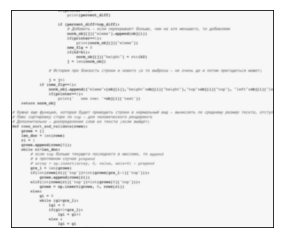

In [733]:
# img_cl = cv2.imread(r'test_real.jpg',0)
# img_cl = cv2.imread(r'img/IMG_2744.JPG',0)
# img_cl = cv2.imread(r'test.png',0)
img_cl = cv2.imread(r'test_multi2.png',0)
img = cv2.cvtColor(img_cl, cv2.COLOR_GRAY2RGB) #numpy array
# plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.imshow(img, interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

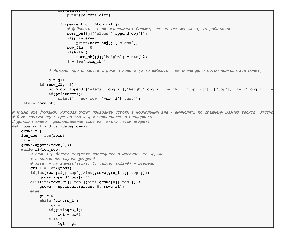

In [734]:
img_demoise = cv2.fastNlMeansDenoising(img,None,10,7,21)
print_img(img_demoise)

В некоторых случаях возможно уменьшение для ускорения распознования, но это приводит к потере данных:
```py
img_small = cv2.resize(img, (0,0), fx=0.95, fy=0.95)
print_img(img_small)
```

Если уменьшить размер в 2 раза, то он текста не видит..

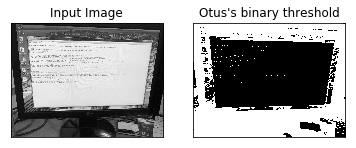

In [491]:
# img = cv2.imread('0.jpg')
b,g,r = cv2.split(img)
rgb_img = cv2.merge([r,g,b])

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# ниже переводиться картинка в треш и угар - попробовать
ret, thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.subplot(121),plt.imshow(rgb_img)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(thresh, 'gray')
plt.title("Otus's binary threshold"), plt.xticks([]), plt.yticks([])
plt.show()

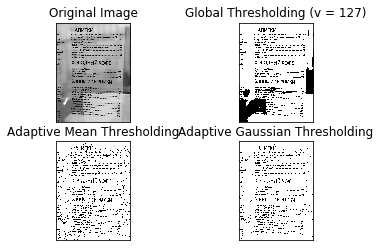

In [480]:
img_b = cv2.medianBlur(cv2.imread(r'img/IMG_2744.JPG',0),5)
ret,th1 = cv2.threshold(img_b,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img_b,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img_b,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    
titles = ['Original Image', 'Global Thresholding (v = 127)',
    'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img_b, th1, th2, th3]
    
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

In [735]:
img = img_demoise

Идея, чтобы народ не мучать - автоматом cropить изображение до миимального распознанного текста и супер быстро искать слово по англ и рус словарю - делать это в цикле с ходом по x и y

In [736]:
# для уменьшения размера - потом додумать
# small = cv2.resize(image, (0,0), fx=0.5, fy=0.5) 
# resized_image = cv2.resize(image, (100, 50)) 

In [737]:
# А что, если картинку разбивать на более малые части, их обрабатывать и потом выдавать результат...?

Источники:
```py
ru_df = pd.read_csv('http://www.ruscorpora.ru/ngrams/1grams-3.zip', delimiter='\t', header=None, names=['freq', 'word']) 
ru_df.to_csv('ru_gram.txt', sep='\t', encoding='utf-8') 
en_df = (pd.read_html('https://en.wiktionary.org/wiki/Wiktionary:Frequency_lists/PG/2006/04/1-10000', header=0)[0].rename(columns={'Word': 'word', 'Count (per billion)': 'freq'})[['word', 'freq']])
en_df.to_csv('en_gram.txt', sep='\t', encoding='utf-8')
```

In [738]:
height, width, channels = img_demoise.shape
print (height, width, channels)
# thheight, thwidth, thchannels = th1.shape
# print (thheight, thwidth, thchannels)

1599 1929 3


In [739]:
def cropDetectLanguage(img, steps=30, validation=5, printer=0): # функция для большой картинки - определение всего
    # Определяем язык в steps шагов (с прерыванием validation, как только очевидно, что за язык)
    height, width, channels = img_demoise.shape
    step_h = math.trunc(height/steps)
    step_w = math.trunc(width/steps)
    crop_img = img
    ru_lm = trigram_lm(RU_DF)
    en_lm = trigram_lm(EN_DF)
    count = 1
    lang_arr = []
    lang = ''
    while(count <= steps):
        crop_img = img[0:(count*step_h), 0:(count*step_w)]
        if(printer==1):
            print_img(crop_img)
        lang_val = detectLanguage(crop_img, ru_lm, en_lm, 0.1, printer)
        if(lang_val!=''):
            lang_arr.append(lang_val)
        if(len(lang_arr)>(validation-1)):
            count = steps
        if(printer==1):
            print(lang_arr)
        count += 1
    rus_l = lang_arr.count('rus')
    eng_l = lang_arr.count('eng')
    if(rus_l>eng_l):
        lang = 'rus'
    elif(rus_l<eng_l):
        lang = 'eng'
    return lang

def detectLanguage(crop_img, ru_lm, en_lm, alpha=0.2, printer=0): # функция для маленькой картинки
    lang = ''
    # здесь перемножаем вероятности всех распознанных слов
#     col_itd_ru = clean(pytesseract.image_to_string(crop_img, lang="rus")).split('\n')
#     col_itd_en = clean(pytesseract.image_to_string(crop_img, lang="eng")).split('\n')
#     if(printer==1):
#         print('RU:')
#         print(col_itd_ru)
#         print('EN:')
#         print(col_itd_en)
    is_rus = detectLanguageRus(pytesseract.image_to_string(crop_img, lang="rus"), ru_lm, alpha, printer)
    is_en = detectLanguageEng(pytesseract.image_to_string(crop_img, lang="eng"), en_lm, alpha, printer)
#     e = math.e
#     for ir in range(len(col_itd_ru)):
#         if(len(col_itd_ru[ir])>4):
#             is_rus *= abs(1 - pow(e,prob(col_itd_ru[ir],ru_lm)))
#     for ie in range(len(col_itd_en)):
#         if(len(col_itd_en[ie])>4):
#             is_en *= abs(1 - pow(e,prob(col_itd_en[ie],en_lm)))
#     if(printer==1):
#         print('RU:'+str(is_rus)+'\nEN:'+str(is_en))
    if(is_rus>is_en):
        lang = 'rus'
    elif(is_rus<is_en):
        lang = 'eng'
    return lang

def detectLanguageRus(text, ru_lm, alpha=0.2, printer=0):
    is_res = 0.0
    col_itd = clean(text).split('\n')
    if(printer==1):
        print('RU:')
        print(col_itd)
    is_rus = 0
    e = math.e
    for ir in range(len(col_itd)):
        if(len(col_itd[ir])>3):
            # is_rus *= abs(1 - pow(e,prob(col_itd[ir],ru_lm)))
            # exponential_moving_average - EMA
            is_rus = alpha * prob(col_itd[ir],ru_lm) + (1 - alpha) * is_rus
    if(printer==1):
        print('RU:'+str(is_rus))
    if (is_rus!=0):
        is_res = is_rus
    return is_res

def detectLanguageEng(text, en_lm, alpha=0.2, printer=0):
    is_res = 0.0
    col_itd = clean(text).split('\n')
    if(printer==1):
        print('EN:')
        print(col_itd)
    is_eng = 0
    e = math.e
    for ir in range(len(col_itd)):
        if(len(col_itd[ir])>3):
            # is_eng *= abs(1 - pow(e,prob(col_itd[ir],en_lm)))
            # exponential_moving_average - EMA
            is_eng = alpha * prob(col_itd[ir],en_lm) + (1 - alpha) * is_eng
    if(printer==1):
        print('EN:'+str(is_eng))
    if (is_eng!=0):
        is_res = is_eng
    return is_res

def clean(s):
    s = re.sub('[^А-Яа-я0-9A-Za-z]', '\n', s, re.UNICODE)
    return s
    
    
def trigram_lm(df):
    model = defaultdict(lambda: defaultdict(lambda: 0))

    # counts
    for _, row in df.iterrows():
        for w1, w2, w3 in nltk.ngrams(row['word'], 3, pad_right=True, pad_left=True):
            model[(w1, w2)][w3] += row['freq']

    # probs
    for w1_w2 in model:
        total_count = float(sum(model[w1_w2].values()))
        for w3 in model[w1_w2]:
            model[w1_w2][w3] /= total_count

    return model

def prob(str, model, c=10**-10):
    res = 1
    for w1, w2, w3 in nltk.ngrams(str, 3, pad_right=True, pad_left=True):
        res *= model[w1, w2][w3] + c
    return math.pow(res, 1/len(str))

In [740]:
%%time
DOCUMENT_LANGUAGE = cropDetectLanguage(img,10,3)
print(DOCUMENT_LANGUAGE)

eng
CPU times: user 498 ms, sys: 98.9 ms, total: 597 ms
Wall time: 5.57 s


#### Итог: нужно уменьшать картинку - теряем в мощности. Плюс надо картинку в ЧБ перевести. Тогда пробегать будем намного быстрее. Легче дописывать документ на более близком расстоянии, чем заниматься фигней.

In [741]:
%%time
print(pytesseract.image_to_string(img, lang=DOCUMENT_LANGUAGE))
# OR explicit beforehand converting
# print(pytesseract.image_to_string(Image.fromarray(img))

if(printer==1):
print(percent_diff)

if (percent_diff>top_diff):
# ﬂoGaBMTb - ec1m neperbIBaeT Eonbwe, HEM Ha 40% Mewaero, To ,aoﬁaB/meM
norm_obj[j]["elems"].append(obj[i])
if(printer==1):
print(norm_obj[j]["elems"])
new_flg = O
if(h2>h1):
norm_obj[j]["height"] = str(h2)
j = len(normLobj)

7f MCTOpMﬂ npo 617M30CTb CTpOKM M HOBOI'O (a T0 BblﬁpOCbl - He O‘leHb A0 M I70TOM anI'O/JMTbCﬂ M0)I(eT)

j = j+1
if (new_flg==1):
norm_obj.append({"elems":[obj[i]],"height":obj[i]["height"],"top":obj[i]["top"], "left":obj[i]["le
if(printer==1):
print(‘ new row: '+obj[i][‘text‘])

return norm_obj

# HyXHa ewe ¢yHKLMﬂ, Koropaﬂ EyAeT anBoAMTb CTpOKM B HopMaﬂbeuZ BMA - Bbllmcmvrb n0 cpeAHeMy pasMep TeCKTa, OTCTym
# ﬂmoc COpTMpOBKy CTOpK no top — ,a/m HEIIOBEHeCKOI'O pEHAepMHI'a
# ﬂOnOﬂHMTeﬂbHO — ,aoonpegenemie C1703 M3 TeKCTa (ECIIM BblﬁAeT)
def rows_sort_and_validate(rows):
grows = []
len_doc = len(rows)
ri = 1
grows.append(rows[0]);
while ri<len_doc:
# ec1m top 5017ber TeKyU/el'o HOCﬂeAHeI'O B Maccmze,

In [742]:
img.size

9253413

In [743]:
%%time
print(pytesseract.image_to_data(img, lang=DOCUMENT_LANGUAGE))

level	page_num	block_num	par_num	line_num	word_num	left	top	width	height	conf	text
1	1	0	0	0	0	0	0	1929	1599	-1	
2	1	1	0	0	0	346	0	379	60	-1	
3	1	1	1	0	0	346	0	379	60	-1	
4	1	1	1	1	0	346	0	244	24	-1	
5	1	1	1	1	1	346	0	244	24	84	if(printer==1):
4	1	1	1	2	0	412	34	313	26	-1	
5	1	1	1	2	1	412	34	313	26	85	print(percent_diff)
2	1	2	0	0	0	346	102	1261	298	-1	
3	1	2	1	0	0	346	102	1261	298	-1	
4	1	2	1	1	0	346	102	446	26	-1	
5	1	2	1	1	1	346	102	30	19	84	if
5	1	2	1	1	2	399	102	393	26	84	(percent_diff>top_diff):
4	1	2	1	2	0	412	133	1195	28	-1	
5	1	2	1	2	1	412	135	18	21	75	#
5	1	2	1	2	2	443	133	136	28	66	ﬂoGaBMTb
5	1	2	1	2	3	599	147	13	3	97	-
5	1	2	1	2	4	633	139	66	16	75	ec1m
5	1	2	1	2	5	716	139	185	22	83	neperbIBaeT
5	1	2	1	2	6	918	133	110	26	73	Eonbwe,
5	1	2	1	2	7	1054	139	49	16	67	HEM
5	1	2	1	2	8	1119	139	33	16	86	Ha
5	1	2	1	2	9	1170	137	47	18	83	40%
5	1	2	1	2	10	1235	139	146	20	81	Mewaero,
5	1	2	1	2	11	1407	139	30	16	88	To
5	1	2	1	2	12	1452	133	155	26	71	,aoﬁaB/meM
4	1	2	1	3	0	412	170	582	26	-

In [744]:

# Здесь доработать функцию, которая будет искать слова по словарю определенного языка и валидировать их
def imageToJSON(input_img, lang, ru_lm, en_lm, printer=0):
    json_obj = []
    itd_str = ''
    if (lang!=''):
        itd_str = pytesseract.image_to_data(input_img, lang=lang)
    else:
        itd_str = pytesseract.image_to_data(input_img)
    rows_strs = itd_str.split('\n')
    headers = rows_strs[0].split('\t') 
    rows = rows_strs[1:]
    for i in range(len(rows)):
        cur_obj = {}
        cols = rows[i].split('\t')
        need_translate = ''
        for h in range(len(headers)):
            if(h < len(cols)):
                if(headers[h]=="text" and len(cols[h])>4):
                    # здесь определяем язык слова и его необходимость изменения
                    need_translate = wordInDocLanguage(cols[h],lang, ru_lm, en_lm)
                    if(need_translate==lang):
                        need_translate = ''
                cur_obj[headers[h]] = cols[h]
            else:
                cur_obj[headers[h]] = ''
        # Валидируем текст на картинке
        if(need_translate!=''):
            json_obj.append(wordAutoLanguage(cur_obj,input_img, lang, ru_lm, en_lm, printer))
        else:
            json_obj.append(cur_obj)
    json_norm = to_rows_normalization(json_obj,0.4,printer)
    json_norm_n = rows_sort_and_validate(json_norm)
    json_str = json.dumps(json_norm_n)
    return json_str

def wordInDocLanguage(word,lang,ru_lm,en_lm):
    # Функция, которая говорит о необходимости переопределить текст
    good_lang = '';
    if(lang=='rus'):
        is_rus = detectLanguageRus(word,ru_lm,0.2,1)
        if(is_rus<0.0001):
            good_lang = 'eng'
    if(lang=='eng'):
        is_eng = detectLanguageEng(word,en_lm,0.2,1)
        if(is_eng<0.0001):
            good_lang = 'rus'
    return good_lang;

def wordAutoLanguage(obj, img, docLang, ru_lm, en_lm, printer):
    if (len(re.sub('[^А-Яа-я0-9A-Za-z]', '', obj["text"]))>0):
        if(printer==1):
            print('------------------')
        to = int(obj["top"])-2#-math.trunc(int(obj["height"])/3)
        ho = int(obj["height"])+4#+math.trunc(int(obj["height"])*2/3)
        wo = int(obj["width"])+4#+math.trunc(int(obj["width"])*2/3)
        lo = int(obj["left"])-2#-math.trunc(int(obj["width"])/3)
        crop_img = img[to:(to+ho), lo:(lo+wo)] # обрезаем
        lang_val = detectLanguage(crop_img, ru_lm, en_lm, 0.5, printer) # пытаемся определить язык
        if(printer==1):
            print_img(crop_img)
            print('   old:'+obj["text"])
            print('   detected lang:'+lang_val)
        if(lang_val!=''): # если язык определели
            obj["text"] = re.sub('[\n+\t+]', '', pytesseract.image_to_string(crop_img, lang=lang_val))
            if(printer==1):
                print('   new:'+obj["text"])
        if(printer==1):
            print('------------------')
    return obj

# Функция, которая должна пробегаться по всем словам, смотреть их расположение и записывать в одну строку
# условием является то, что, если 2 элемента перекрываются по top или top+width

# Переделать алгоритм нахер весь - нужно вычислять "расстояние" между текстом
# огромный минус - если текст маленький, но немного удален - мы его не детектим
# такая же херня, если текст очень большой, то он начинает все жрать - неверно
# нужно придумать метрику, основанную на корреляции высоты и близости векторов - допустимые размеры склеивания
# Пока можно понимать на сколько одно перекрывает другое и если это больше 40%, то клеить

# Также нужно сделать функцию сортировки каждой строки - по left+width - работать должно аналогично
def to_rows_normalization(obj,top_diff = 0.4, printer=0):
    # top_diff - описывает какой процент перекрытия по высоте от меньшего нужно,
    # чтобы элементы схлопнулись в строчку
    norm_obj = []
    # предположим, что первый элемент - первая строка
    first = {}
    objs_len = len(obj)
    ind = 0
    while ind < objs_len:
        if (len(re.sub('[^А-Яа-я0-9A-Za-z]', '', obj[ind]["text"]))>0):
            first = obj[ind]
            ind = objs_len
        ind = ind + 1
    norm_obj.append({"elems":[],"height":"0","top":"0", "left":"0"})
    for i in range(objs_len): 
        if(printer==1):
            print(str(i)+' of '+str(len(obj))+' total rows: '+str(len(norm_obj)))
        t2 = int(obj[i]["top"])
        h2 = int(obj[i]["height"])
        w2 = int(obj[i]["width"])
        if(printer==1):
            print(obj[i]["height"]+':'+str(t2))
        if (h2>0 and w2>0 and len(re.sub('[^А-Яа-я0-9A-Za-z]', '', obj[i]["text"]))>0):
            j = 0
            new_flg = 1
            while j < len(norm_obj):
                t1 = int(norm_obj[j]["top"])
                h1 = int(norm_obj[j]["height"])
                add_flg = 0
                
                # История про перекрытия
                if(printer==1):
                    print('-   '+str(t1)+' < '+str(t2+h2)+' && '+str(t1+h1)+' > '+str(t2+h2))
                    print('--   '+str(t2)+' < '+str(t1+h1)+' && '+str(t2+h2)+' > '+str(t1+h1))
                if (t1<t2+h2 and t1+h1>=t2+h2):
                    add_flg = 1
                elif (t2<t1+h1 and t2+h2>=t1+h1):
                    add_flg = 1
                if (add_flg==1):
                    minim_h = h2
                    if(h1<h2): 
                        minim_h = h1
                    diff_sq = 0
                    if ((t1+h1)>(t2+h2)):
                        diff_sq = h1 - (t1+h1-t2-h2)
                    else:
                        diff_sq = h2 - (t2+h2-t1-h1)
                    percent_diff = abs(diff_sq/minim_h);
                    if(printer==1):
                        print(percent_diff)
                    
                    if (percent_diff>top_diff):
                        # Добавить - если перекрывает больше, чем на 40% меньшего, то добавляем
                        norm_obj[j]["elems"].append(obj[i])
                        if(printer==1):
                            print(norm_obj[j]["elems"])
                        new_flg = 0
                        if(h2>h1):
                            norm_obj[j]["height"] = str(h2)
                        j = len(norm_obj)
                        
                # История про близость строки и нового (а то выбросы - не очень да и потом пригодиться может)
                
                j = j+1
            if (new_flg==1):
                norm_obj.append({"elems":[obj[i]],"height":obj[i]["height"],"top":obj[i]["top"], "left":obj[i]["left"]})
                if(printer==1):
                    print('   new row: '+obj[i]['text'])
    return norm_obj

# Нужна еще функция, которая будет приводить строки в нормальный вид - вычислять по среднему размер тескта, отступы
# Плюс сортировку сторк по top - для человеческого рендеринга
# Дополнительно - доопределение слов из текста (если выйдет)
def rows_sort_and_validate(rows):
    grows = []
    len_doc = len(rows)
    ri = 1
    grows.append(rows[0]);
    while ri<len_doc:
        # если top больше текущего последнего в массиве, то append
        # в противном случае prepend
        # array = np.insert(array, 0, value, axis=0) - prepend
        grs_l = len(grows)
        if(int(rows[ri]['top'])>int(grows[grs_l-1]['top'])):
            grows.append(rows[ri])
        elif(int(rows[ri]['top'])<int(grows[0]['top'])):
            grows = np.insert(grows, 0, rows[ri])
        else:
            gi = 0
            while (gi<grs_l):
                lgi = 0
                if(gi+1<grs_l): 
                    lgi = gi+1
                else : 
                    lgi = gi
                t0 = int(grows[gi]['top']);
                t1 = int(grows[lgi]['top']);
                ti = int(rows[ri]['top']);
                if(ti<t0 and ti>t1):
                    # ti appned after t0
                    grows = np.insert(grows, (gi+1), rows[ri])
                gi = gi + 1
        ri = ri + 1
        
        #Здесь же сделать историю по валидации (сортировки) слов в строке
        
    return grows

Так, понимать тессеракт научились. Теперь зажбарим это все в файл и херакнем по нему JS на конфиг html (для начала)
Дальше проблема заключается в том, что нужно отслеживать состояние документа и сравнивать старое и новое. 

Обрабатываем все это в JS (эмулируя какую-либо платформу/браузер - используем движок V8 от mozilla)

https://github.com/sqreen/PyMiniRacer

EN:
['if', 'printer', '', '1', '', '']
EN:0.018066245791491468
EN:
['print', 'percent', 'diff', '']
EN:0.02049764672759558
EN:
['', 'percent', 'diff', 'top', 'diff', '', '']
EN:0.021134341911056106
EN:
['', 'oGaBMTb']
EN:5.37106432302764e-13
------------------
RU:
['Добавить']
RU:1.3396187361178332e-05
EN:
['', 'o', 'aBMTb']
EN:3.2576981174979563e-13


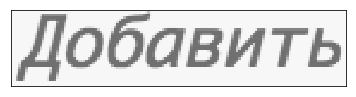

   old:ﬂoGaBMTb
   detected lang:rus
   new:Добавить
------------------
EN:
['neperbIBaeT']
EN:9.033256523418516e-11
------------------
RU:
['перекрывает']
RU:4.187964029064025e-05
EN:
['neperbIBaeT']
EN:2.2583141308546287e-10


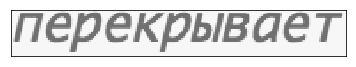

   old:neperbIBaeT
   detected lang:rus
   new:перекрывает
------------------
EN:
['Eonbwe', '']
EN:2.0854106578818179e-10
------------------
RU:
['больше', '']
RU:0.10266913492521026
EN:
['60', '7bwe', '']
EN:3.5452191756554416e-11


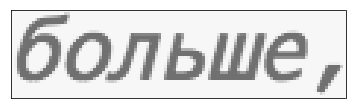

   old:Eonbwe,
   detected lang:rus
   new:больше,
------------------
EN:
['Mewaero', '']
EN:8.58761042446756e-12
------------------
RU:
['МЕНЬШЕГО', '']
RU:2.57538721860613e-11
EN:
['Mewaero', '']
EN:2.14690260611689e-11


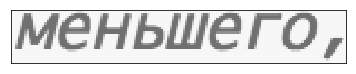

   old:Mewaero,
   detected lang:rus
   new:МЕНЬШЕГО,
------------------
EN:
['', 'ao', 'aB', 'meM']
EN:0
------------------
RU:
['добавляем']
RU:4.07950653320074e-05
EN:
['', 'qo', 'aB', 'meM']
EN:0


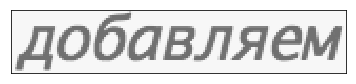

   old:,aoﬁaB/meM
   detected lang:rus
   new:добавляем
------------------
EN:
['norm', 'obj', 'j', '', '', 'elems', '', '', 'append', 'obj', 'i', '', '']
EN:0.03188883632130069
EN:
['if', 'printer', '', '1', '', '']
EN:0.018066245791491468
EN:
['print', 'norm', 'obj', 'j', '', '', 'elems', '', '', '']
EN:0.020587866977063003
EN:
['new', 'flg']
EN:0
------------------
RU:
['пеш', '', '', '19']
RU:0
EN:
['newiflg']
EN:1.8638550789553522e-07


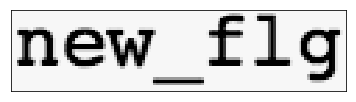

   old:new_flg
   detected lang:eng
   new:newiflg
------------------
EN:
['if', 'h2', 'h1', '', '']
EN:0
------------------
RU:
['', '', '', 'Ь2', 'Ь1', '', '']
RU:0
EN:
['if', 'h2', 'h1', '', '']
EN:0


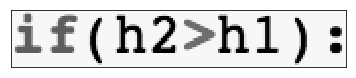

   old:if(h2>h1):
   detected lang:
------------------
EN:
['norm', 'obj', 'j', '', '', 'height', '', '']
EN:0.04019367079050988
EN:
['str', 'h2', '']
EN:0
------------------
RU:
['5йг', 'Ь2', '']
RU:0
EN:
['str', 'h2', '']
EN:0


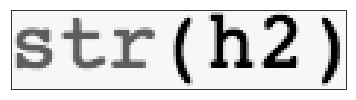

   old:str(h2)
   detected lang:
------------------
EN:
['len', 'normLobj', '']
EN:2.4707781059488737e-08
------------------
RU:
['1еп', 'по', 'сш', 'оь', '', '', '', '', '']
RU:0
EN:
['len', 'normiobj', '', '']
EN:8.354163199506395e-07


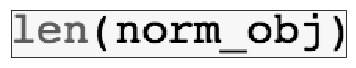

   old:len(normLobj)
   detected lang:eng
   new:len(normiobj )
------------------
EN:
['MCTOpM', '']
EN:1.6069883351799186e-13
------------------
RU:
['История']
RU:9.237438049018635e-05
EN:
['Mcropmv']
EN:2.926909153108927e-10


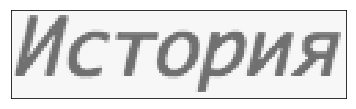

   old:MCTOpMﬂ
   detected lang:rus
   new:История
------------------
EN:
['617M30CTb']
EN:1.198968500637884e-13
------------------
RU:
['близость']
RU:1.2712270759818572e-07
EN:
['', 'nmaocrb']
EN:1.1080617110714375e-12


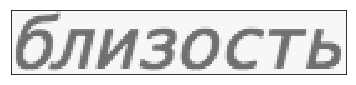

   old:617M30CTb
   detected lang:rus
   new:близость
------------------
EN:
['CTpOKM']
EN:1.2120131202499507e-13
------------------
RU:
['строки']
RU:3.832978024841671e-05
EN:
['CTpOKM']
EN:3.0300328006248767e-13


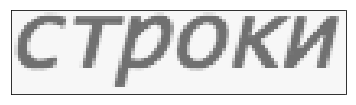

   old:CTpOKM
   detected lang:rus
   new:строки
------------------
EN:
['HOBOI', 'O']
EN:3.453362639998846e-14
------------------
RU:
['']
RU:0
EN:
['']
EN:0


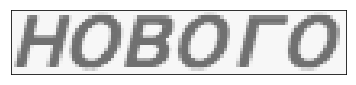

   old:HOBOI'O
   detected lang:
------------------
EN:
['Bbl', 'pOCbl']
EN:8.927433171044436e-12
------------------
RU:
['выбросы']
RU:4.290423112831098e-06
EN:
['Bbl', 'pocu']
EN:3.506896292752897e-09


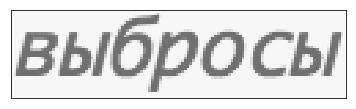

   old:BblﬁpOCbl
   detected lang:rus
   new:выбросы
------------------
EN:
['O', 'leHb']
EN:5.304693959272814e-12
------------------
RU:
['']
RU:0
EN:
['']
EN:0


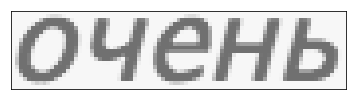

   old:O‘leHb
   detected lang:
------------------
EN:
['I70TOM']
EN:1.3452153416557716e-13
------------------
RU:
['']
RU:0
EN:
['']
EN:0


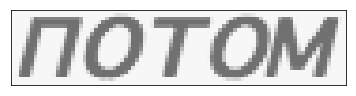

   old:I70TOM
   detected lang:
------------------
EN:
['anI', 'O', 'JMTbC', '']
EN:1.9999999999999966e-15
------------------
RU:
['ПРИГОДИТЬ', 'СЯ']
RU:2.1626367782936352e-12
EN:
['', 'pMI', 'O', 'MTb', 'CH']
EN:0


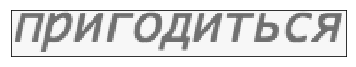

   old:anI'O/JMTbCﬂ
   detected lang:rus
   new:ПРИГОДИТЬ СЯ
------------------
EN:
['M0', 'I', 'eT', '']
EN:0
------------------
RU:
['може', 'т', '', '']
RU:0.09986449701155707
EN:
['Moxe', 'T', '', '']
EN:1.1387911864745269e-11


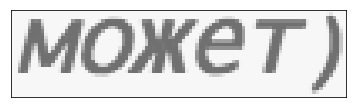

   old:M0)I(eT)
   detected lang:rus
   new:може т )
------------------
EN:
['', 'new', 'flg', '', '1', '', '']
EN:0
------------------
RU:
['', '', 'пеы', '', '19', '', '1', '', '', '', '']
RU:0
EN:
['', 'newiflg', '', '1', '', '', '']
EN:1.8638550789553522e-07


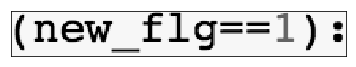

   old:(new_flg==1):
   detected lang:eng
   new:(newiflg==1) :
------------------
EN:
['norm', 'obj', 'append', '', '', 'elems', '', '', 'obj', 'i', '', '', '', 'height', '', 'obj', 'i', '', '', 'height', '', '', '', 'top', '', 'obj', 'i', '', '', 'top', '', '', '']
EN:0.07676240932452527
EN:
['', 'left', '', 'obj', 'i', '', '', 'le']
EN:0.011974469354322143
EN:
['if', 'printer', '', '1', '', '']
EN:0.018066245791491468
EN:
['print', '', '']
EN:0.012949624160288477
EN:
['', '', 'obj', 'i', '', '', 'text', '', '', '']
EN:9.59628974400833e-05
------------------
RU:
['', '', 'оЬ', '', '', '', '', '', '', '1', 'ех', '', '', '', '', '']
RU:0
EN:
['', '', 'obj', 'i', '', '', 'text', '', '', '']
EN:0.0002399072436002082


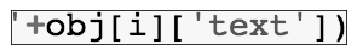

   old:'+obj[i][‘text‘])
   detected lang:eng
   new:'obj[i]['text'])
------------------
EN:
['return']
EN:0.01760896003677536
EN:
['norm', 'obj']
EN:0.009561220867631151
EN:
['HyXHa']
EN:3.453362640067914e-12
------------------
RU:
['Нужна']
RU:0.0005004215936054362
EN:
['HyXHa']
EN:8.633406600169784e-12


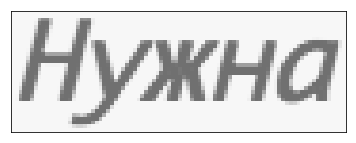

   old:HyXHa
   detected lang:rus
   new:Нужна
------------------
EN:
['', 'yHKLM', '', '']
EN:8.885582630401421e-14
------------------
RU:
['Функция', '']
RU:4.0332242539998816e-10
EN:
['', 'yHKuMH', '']
EN:5.478772487252451e-13


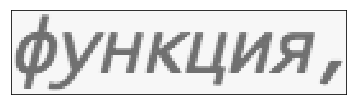

   old:¢yHKLMﬂ,
   detected lang:rus
   new:Функция,
------------------
EN:
['Koropa', '']
EN:1.1228473642600158e-11
------------------
RU:
['К', 'оторая']
RU:0.05349556370584113
EN:
['K', 'ompan']
EN:0.0003690047844793528


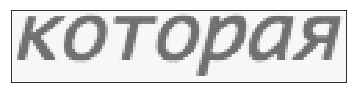

   old:Koropaﬂ
   detected lang:rus
   new:К оторая
------------------
EN:
['EyAeT']
EN:4.388190158496886e-14
------------------
RU:
['будет']
RU:0.09349013628347924
EN:
['', 'yger']
EN:8.284592258584181e-07


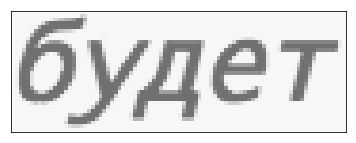

   old:EyAeT
   detected lang:rus
   new:будет
------------------
EN:
['anBoAMTb']
EN:1.4098353634439354e-11
------------------
RU:
['ПРИБОДИТЬ']
RU:2.1626367782936352e-12
EN:
['', 'pMBO', 'MTb']
EN:5.768870228296725e-14


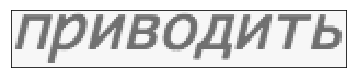

   old:anBoAMTb
   detected lang:rus
   new:ПРИБОДИТЬ
------------------
EN:
['CTpOKM']
EN:1.2120131202499507e-13
------------------
RU:
['строки']
RU:3.832978024841671e-05
EN:
['CTpOKM']
EN:3.0300328006248767e-13


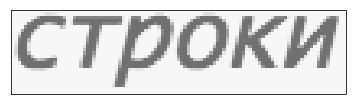

   old:CTpOKM
   detected lang:rus
   new:строки
------------------
EN:
['HopMa', 'beuZ']
EN:1.0657320136936756e-11
------------------
RU:
['нормальный']
RU:9.427110855354242e-06
EN:
['HopMa', 'beuZ']
EN:2.4053278362290952e-11


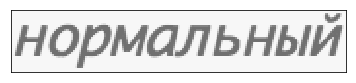

   old:HopMaﬂbeuZ
   detected lang:rus
   new:нормальный
------------------
EN:
['Bbllmcmvrb']
EN:1.9999999999999973e-13
------------------
RU:
['']
RU:0
EN:
['']
EN:0


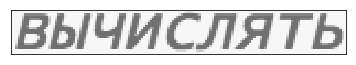

   old:Bbllmcmvrb
   detected lang:
------------------
EN:
['cpeAHeMy']
EN:1.2482948795727077e-11
------------------
RU:
['среднему']
RU:0.05094101929174361
EN:
['cpeAHeMy']
EN:3.120737198931769e-11


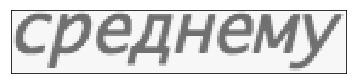

   old:cpeAHeMy
   detected lang:rus
   new:среднему
------------------
EN:
['pasMep']
EN:5.679776203679438e-07
------------------
RU:
['размер']
RU:3.730518785333512e-05
EN:
['pasMep']
EN:1.4199440509198594e-06


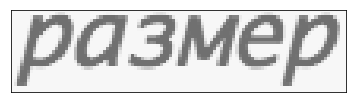

   old:pasMep
   detected lang:rus
   new:размер
------------------
EN:
['TeCKTa', '']
EN:4.308869380135589e-13
------------------
RU:
['тескта', '']
RU:1.0337310903095775e-06
EN:
['TeCKTa', '']
EN:1.0772173450338972e-12


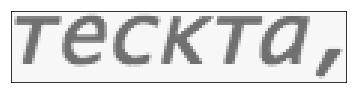

   old:TeCKTa,
   detected lang:rus
   new:тескта,
------------------
EN:
['OTCTym']
EN:4.308869380135589e-13
------------------
RU:
['0', 'ТСТУПА']
RU:2.1220243300057208e-11
EN:
['0', 'TCTyI', 'IA']
EN:4.999999999999991e-15


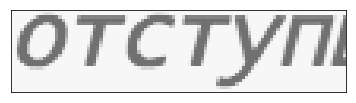

   old:OTCTym
   detected lang:rus
   new:0 ТСТУПА
------------------
EN:
['COpTMpOBKy']
EN:9.343646320125834e-12
------------------
RU:
['сортировку']
RU:2.7054145427020045e-08
EN:
['copmposKy']
EN:4.5787386270823833e-07


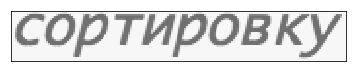

   old:COpTMpOBKy
   detected lang:eng
   new:copmposKy
------------------
EN:
['CTOpK']
EN:4.365186327692753e-14
------------------
RU:
['сторк']
RU:9.786830195203143e-06
EN:
['CTOpK']
EN:1.0912965819231882e-13


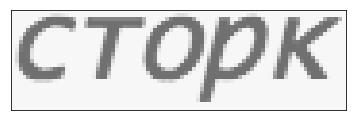

   old:CTOpK
   detected lang:rus
   new:сторк
------------------
EN:
['HEIIOBEHeCKOI', 'O']
EN:1.7314872573222272e-12
------------------
RU:
['ЧЕЛОВЕЧЕСКОГО']
RU:3.125674798257265e-11
EN:
['He', 'OBe', 'IecKOI', 'O']
EN:3.363038354139429e-13


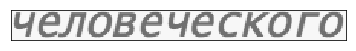

   old:HEIIOBEHeCKOI'O
   detected lang:rus
   new:ЧЕЛОВЕЧЕСКОГО
------------------
EN:
['pEHAepMHI', 'a']
EN:9.892496181727263e-13
------------------
RU:
['рендеринга']
RU:5.332502399363748e-06
EN:
['pengpMHra']
EN:3.0621251924241976e-08


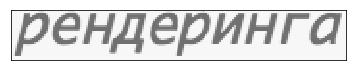

   old:pEHAepMHI'a
   detected lang:rus
   new:рендеринга
------------------
EN:
['', 'OnO', 'HMTe', 'bHO']
EN:2.2261028926609317e-12
------------------
RU:
['Дополнительно']
RU:6.563357032558254e-05
EN:
['', 'ononHMTe', 'bHo']
EN:4.888670947110619e-08


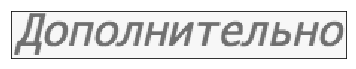

   old:ﬂOnOﬂHMTeﬂbHO
   detected lang:rus
   new:Дополнительно
------------------
EN:
['', 'aoonpegenemie']
EN:3.80745493004071e-08
------------------
RU:
['ДООПРЕДЕЛЕНИЕ']
RU:5.523821677726892e-12
EN:
['', 'qoonpege', 'eHMe']
EN:2.2716316110642132e-09


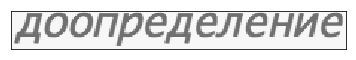

   old:,aoonpegenemie
   detected lang:eng
   new:,qoonpegeﬂeHMe
------------------
EN:
['C1703']
EN:4.365186327692753e-14
------------------
RU:
['']
RU:0
EN:
['']
EN:0


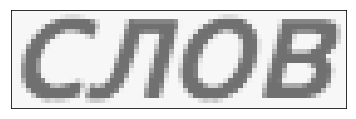

   old:C1703
   detected lang:
------------------
EN:
['TeKCTa']
EN:4.308869380135589e-13
------------------
RU:
['']
RU:0
EN:
['']
EN:0


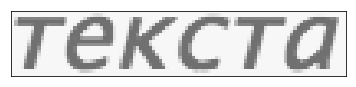

   old:TeKCTa
   detected lang:
------------------
EN:
['', 'ECIIM']
EN:4.388190158496886e-14
------------------
RU:
['', '', 'если']
RU:0.06524243591028955
EN:
['', '6611M']
EN:4.999999999999991e-15


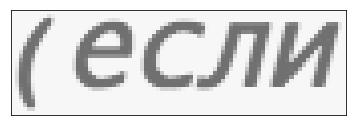

   old:(ECIIM
   detected lang:rus
   new:( если
------------------
EN:
['Bbl', 'AeT', '']
EN:0
------------------
RU:
['выйд', 'е', 'т', '', '']
RU:7.439236644717507e-07
EN:
['swig', 'e', 'T', '', '']
EN:2.6261764968286695e-07


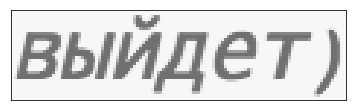

   old:BblﬁAeT)
   detected lang:rus
   new:выйд е т )
------------------
EN:
['rows', 'sort', 'and', 'validate', 'rows', '', '']
EN:0.013296706154620228
EN:
['grows']
EN:0.0066424289610566845
EN:
['len', 'doc']
EN:0
------------------
RU:
['1еп', 'аос']
RU:0
EN:
['lenidoc']
EN:1.4748833533596988e-07


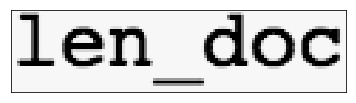

   old:len_doc
   detected lang:eng
   new:lenidoc
------------------
EN:
['len', 'rows', '']
EN:0.004394528983821619
EN:
['grows', 'append', 'rows', '0', '', '', '']
EN:0.026284683766672288
EN:
['while']
EN:0.025508670945724343
EN:
['ri', 'len', 'doc', '']
EN:0
------------------
RU:
['', 'с', '', '1еп', '', '', 'ос', '', '']
RU:0
EN:
['ri', 'len7doc', '', '']
EN:1.048776288545064e-08


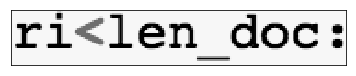

   old:ri<len_doc:
   detected lang:eng
   new:ri<len7doc :
------------------
EN:
['5017ber']
EN:3.185476766233864e-10
------------------
RU:
['больше']
RU:0.10266913492521026
EN:
['60', '7bwe']
EN:3.5452191756554416e-11


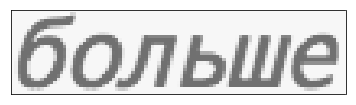

   old:5017ber
   detected lang:rus
   new:больше
------------------
EN:
['TeKyU', 'el', 'o']
EN:1.9999999999999966e-15
------------------
RU:
['ТЕКУЩЕ', 'Г', '0']
RU:4.571762829579796e-13
EN:
['TeKyU', 'e', 'I', 'O']
EN:4.999999999999991e-15


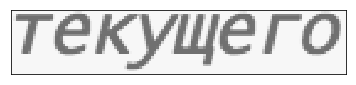

   old:TeKyU/el'o
   detected lang:rus
   new:ТЕКУЩЕ Г 0
------------------
EN:
['HOC', 'eAHeI', 'O']
EN:8.554766870682189e-14
------------------
RU:
['ПОСЛЕДНЕ', 'Г', '0']
RU:1.4604452547169465e-12
EN:
['nocnegHe', 'I', 'O']
EN:5.398630288279725e-10


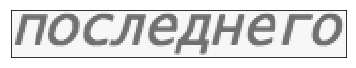

   old:HOCﬂeAHeI'O
   detected lang:eng
   new:nocnegHe I'O
------------------
EN:
['Maccmze', '']
EN:2.8586544224501645e-09
------------------
RU:
['массиве', '']
RU:6.016451463554001e-06
EN:
['MaCCMBe', '']
EN:3.929556762101798e-10


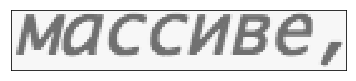

   old:Maccmze,
   detected lang:rus
   new:массиве,
------------------
EN:
['append']
EN:0.022048750309717986
EN:
['I', 'IpOTMBHOM']
EN:7.126416588906637e-13
------------------
RU:
['противном']
RU:0.0040314364724612865
EN:
['npOTMBHOM']
EN:2.583507569941448e-12


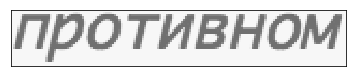

   old:I'IpOTMBHOM
   detected lang:rus
   new:противном
------------------
EN:
['cnyqae']
EN:1.066791598786409e-11
------------------
RU:
['случае']
RU:0.06565277796449524
EN:
['cnyuae']
EN:2.6669789969660225e-11


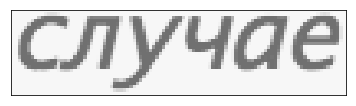

   old:cnyqae
   detected lang:rus
   new:случае
------------------
EN:
['prepend']
EN:0.0007594913703380629
EN:
['array']
EN:3.294577918683998e-06
------------------
RU:
['акта']
RU:2.6272479692499973e-07
EN:
['arra']
EN:5.577767410234313e-07


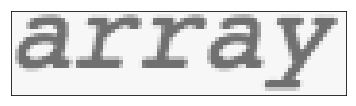

   old:array
   detected lang:eng
   new:arra
------------------
EN:
['np', 'insert', 'array', '']
EN:0.006917195767402885
EN:
['value', '']
EN:0.01054186481179327
EN:
['axis', '0', '']
EN:1.1416667865822486e-06
------------------
RU:
['ах', '5', '0', '']
RU:0
EN:
['axis', '0', '']
EN:2.854166966455621e-06


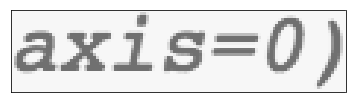

   old:axis=0)
   detected lang:eng
   new:axis=0)
------------------
EN:
['prepend']
EN:0.0007594913703380629
EN:
['grs', 'l']
EN:0
------------------
RU:
['']
RU:0
EN:
['']
EN:0


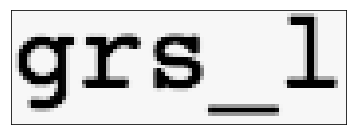

   old:grs_l
   detected lang:
------------------
EN:
['len', 'grows', '']
EN:0.0066424289610566845
EN:
['if', 'int', 'rows', 'ri', '', '', 'top', '', '', '', 'int', 'grows', 'grs', 'l', '1', '', '', 'top', '', '', '', '', '']
EN:0.01015805214811398
EN:
['grows', 'append', 'rows', 'ri', '', '']
EN:0.026284683766672288
EN:
['elif', 'int', 'rows', 'ri', '', '', 'top', '', '', '', 'int', 'grows', '0', '', '', 'top', '', '', '', '', '']
EN:0.015823214022177318
EN:
['grows']
EN:0.0066424289610566845
EN:
['np', 'insert', 'grows', '']
EN:0.013556330150540885
EN:
['rows', 'ri', '', '']
EN:0.004394528983821619
EN:
['else', '']
EN:0.0066406105026516815
EN:
['while']
EN:0.025508670945724343
EN:
['', 'gi', 'grs', 'l', '', '']
EN:0
------------------
RU:
['', '9', '', '', '3', 'сз', '1', '', '', '']
RU:0
EN:
['', 'gi', 'grsil', '', '', '']
EN:5.640140419599539e-06


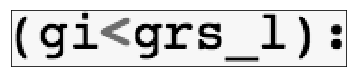

   old:(gi<grs_l):
   detected lang:eng
   new:(gi<grsil) :
------------------
EN:
['if', 'gi', '1', 'grs', 'l', '', '']
EN:0
------------------
RU:
['', '', '', '', '', '9', '', '1', '915', '1', '', '', '']
RU:0
EN:
['if', '', '', 'gi', '1', 'grs', 'l', '', '', '']
EN:0


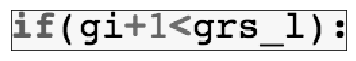

   old:if(gi+1<grs_l):
   detected lang:
------------------
0 of 223 total rows: 1
1599:0
1 of 223 total rows: 1
60:0
2 of 223 total rows: 1
60:0
3 of 223 total rows: 1
24:0
4 of 223 total rows: 1
24:0
-   0 < 24 && 0 > 24
--   0 < 0 && 24 > 0
   new row: if(printer==1):
5 of 223 total rows: 2
26:34
6 of 223 total rows: 2
26:34
-   0 < 60 && 0 > 60
--   34 < 0 && 60 > 0
-   0 < 60 && 24 > 60
--   34 < 24 && 60 > 24
   new row: print(percent_diff)
7 of 223 total rows: 3
298:102
8 of 223 total rows: 3
298:102
9 of 223 total rows: 3
26:102
10 of 223 total rows: 3
19:102
-   0 < 121 && 0 > 121
--   102 < 0 && 121 > 0
-   0 < 121 && 24 > 121
--   102 < 24 && 121 > 24
-   34 < 121 && 60 > 121
--   102 < 60 && 121 > 60
   new row: if
11 of 223 total rows: 4
26:102
-   0 < 128 && 0 > 128
--   102 < 0 && 128 > 0
-   0 < 128 && 24 > 128
--   102 < 24 && 128 > 24
-   34 < 128 && 60 > 128
--   102 < 60 && 128 > 60
-   102 < 128 && 121 > 128
--   102 < 121 && 128 > 121
1.0
[{'level': '5', 'page_num

19:544
-   0 < 563 && 0 > 563
--   544 < 0 && 563 > 0
-   0 < 563 && 24 > 563
--   544 < 24 && 563 > 24
-   34 < 563 && 60 > 563
--   544 < 60 && 563 > 60
-   102 < 563 && 128 > 563
--   544 < 128 && 563 > 128
-   133 < 563 && 161 > 563
--   544 < 161 && 563 > 161
-   170 < 563 && 196 > 563
--   544 < 196 && 563 > 196
-   204 < 563 && 228 > 563
--   544 < 228 && 563 > 228
-   238 < 563 && 264 > 563
--   544 < 264 && 563 > 264
-   273 < 563 && 298 > 563
--   544 < 298 && 563 > 298
-   306 < 563 && 330 > 563
--   544 < 330 && 563 > 330
-   340 < 563 && 366 > 563
--   544 < 366 && 563 > 366
-   374 < 563 && 400 > 563
--   544 < 400 && 563 > 400
-   441 < 563 && 469 > 563
--   544 < 469 && 563 > 469
-   510 < 563 && 534 > 563
--   544 < 534 && 563 > 534
   new row: if
74 of 223 total rows: 15
25:545
-   0 < 570 && 0 > 570
--   545 < 0 && 570 > 0
-   0 < 570 && 24 > 570
--   545 < 24 && 570 > 24
-   34 < 570 && 60 > 570
--   545 < 60 && 570 > 60
-   102 < 570 && 128 > 570
--   545 < 128 && 

--   751 < 604 && 771 > 604
-   612 < 771 && 636 > 771
--   751 < 636 && 771 > 636
-   646 < 771 && 670 > 771
--   751 < 670 && 771 > 670
-   682 < 771 && 708 > 771
--   751 < 708 && 771 > 708
-   745 < 771 && 773 > 771
--   751 < 773 && 771 > 773
1.3
[{'level': '5', 'page_num': '1', 'block_num': '6', 'par_num': '1', 'line_num': '1', 'word_num': '2', 'left': '43', 'top': '745', 'width': '84', 'height': '28', 'conf': '68', 'text': 'Нужна'}, {'level': '5', 'page_num': '1', 'block_num': '6', 'par_num': '1', 'line_num': '1', 'word_num': '3', 'left': '145', 'top': '751', 'width': '49', 'height': '20', 'conf': '73', 'text': 'ewe'}]
96 of 223 total rows: 20
29:744
-   0 < 773 && 0 > 773
--   744 < 0 && 773 > 0
-   0 < 773 && 24 > 773
--   744 < 24 && 773 > 24
-   34 < 773 && 60 > 773
--   744 < 60 && 773 > 60
-   102 < 773 && 128 > 773
--   744 < 128 && 773 > 128
-   133 < 773 && 161 > 773
--   744 < 161 && 773 > 161
-   170 < 773 && 196 > 773
--   744 < 196 && 773 > 196
-   204 < 773 && 228 

-   0 < 773 && 0 > 773
--   751 < 0 && 773 > 0
-   0 < 773 && 24 > 773
--   751 < 24 && 773 > 24
-   34 < 773 && 60 > 773
--   751 < 60 && 773 > 60
-   102 < 773 && 128 > 773
--   751 < 128 && 773 > 128
-   133 < 773 && 161 > 773
--   751 < 161 && 773 > 161
-   170 < 773 && 196 > 773
--   751 < 196 && 773 > 196
-   204 < 773 && 228 > 773
--   751 < 228 && 773 > 228
-   238 < 773 && 264 > 773
--   751 < 264 && 773 > 264
-   273 < 773 && 298 > 773
--   751 < 298 && 773 > 298
-   306 < 773 && 330 > 773
--   751 < 330 && 773 > 330
-   340 < 773 && 366 > 773
--   751 < 366 && 773 > 366
-   374 < 773 && 400 > 773
--   751 < 400 && 773 > 400
-   441 < 773 && 469 > 773
--   751 < 469 && 773 > 469
-   510 < 773 && 534 > 773
--   751 < 534 && 773 > 534
-   544 < 773 && 569 > 773
--   751 < 569 && 773 > 569
-   578 < 773 && 604 > 773
--   751 < 604 && 773 > 604
-   612 < 773 && 636 > 773
--   751 < 636 && 773 > 636
-   646 < 773 && 670 > 773
--   751 < 670 && 773 > 670
-   682 < 773 && 708 > 773


[{'level': '5', 'page_num': '1', 'block_num': '6', 'par_num': '1', 'line_num': '2', 'word_num': '2', 'left': '43', 'top': '779', 'width': '68', 'height': '22', 'conf': '81', 'text': 'ﬂmoc'}, {'level': '5', 'page_num': '1', 'block_num': '6', 'par_num': '1', 'line_num': '2', 'word_num': '3', 'left': '129', 'top': '785', 'width': '168', 'height': '22', 'conf': '81', 'text': 'copmposKy'}, {'level': '5', 'page_num': '1', 'block_num': '6', 'par_num': '1', 'line_num': '2', 'word_num': '4', 'left': '314', 'top': '785', 'width': '83', 'height': '22', 'conf': '86', 'text': 'сторк'}, {'level': '5', 'page_num': '1', 'block_num': '6', 'par_num': '1', 'line_num': '2', 'word_num': '5', 'left': '413', 'top': '785', 'width': '33', 'height': '16', 'conf': '88', 'text': 'no'}, {'level': '5', 'page_num': '1', 'block_num': '6', 'par_num': '1', 'line_num': '2', 'word_num': '6', 'left': '465', 'top': '784', 'width': '48', 'height': '22', 'conf': '88', 'text': 'top'}, {'level': '5', 'page_num': '1', 'block_nu

--   919 < 0 && 944 > 0
-   0 < 944 && 24 > 944
--   919 < 24 && 944 > 24
-   34 < 944 && 60 > 944
--   919 < 60 && 944 > 60
-   102 < 944 && 128 > 944
--   919 < 128 && 944 > 128
-   133 < 944 && 161 > 944
--   919 < 161 && 944 > 161
-   170 < 944 && 196 > 944
--   919 < 196 && 944 > 196
-   204 < 944 && 228 > 944
--   919 < 228 && 944 > 228
-   238 < 944 && 264 > 944
--   919 < 264 && 944 > 264
-   273 < 944 && 298 > 944
--   919 < 298 && 944 > 298
-   306 < 944 && 330 > 944
--   919 < 330 && 944 > 330
-   340 < 944 && 366 > 944
--   919 < 366 && 944 > 366
-   374 < 944 && 400 > 944
--   919 < 400 && 944 > 400
-   441 < 944 && 469 > 944
--   919 < 469 && 944 > 469
-   510 < 944 && 534 > 944
--   919 < 534 && 944 > 534
-   544 < 944 && 569 > 944
--   919 < 569 && 944 > 569
-   578 < 944 && 604 > 944
--   919 < 604 && 944 > 604
-   612 < 944 && 636 > 944
--   919 < 636 && 944 > 636
-   646 < 944 && 670 > 944
--   919 < 670 && 944 > 670
-   682 < 944 && 708 > 944
--   919 < 708 && 944 >

-   813 < 1078 && 841 > 1078
--   1056 < 841 && 1078 > 841
-   851 < 1078 && 877 > 1078
--   1056 < 877 && 1078 > 877
-   889 < 1078 && 908 > 1078
--   1056 < 908 && 1078 > 908
-   919 < 1078 && 944 > 1078
--   1056 < 944 && 1078 > 944
-   952 < 1078 && 971 > 1078
--   1056 < 971 && 1078 > 971
-   987 < 1078 && 1010 > 1078
--   1056 < 1010 && 1078 > 1010
-   1020 < 1078 && 1046 > 1078
--   1056 < 1046 && 1078 > 1046
-   1057 < 1078 && 1073 > 1078
--   1056 < 1073 && 1078 > 1073
1.0625
[{'level': '5', 'page_num': '1', 'block_num': '6', 'par_num': '1', 'line_num': '10', 'word_num': '2', 'left': '179', 'top': '1057', 'width': '66', 'height': '16', 'conf': '79', 'text': 'ec1m'}, {'level': '5', 'page_num': '1', 'block_num': '6', 'par_num': '1', 'line_num': '10', 'word_num': '3', 'left': '263', 'top': '1056', 'width': '48', 'height': '22', 'conf': '79', 'text': 'top'}]
156 of 223 total rows: 29
22:1051
-   0 < 1073 && 0 > 1073
--   1051 < 0 && 1073 > 0
-   0 < 1073 && 24 > 1073
--   1051 < 2

--   1091 < 801 && 1107 > 801
-   813 < 1107 && 841 > 1107
--   1091 < 841 && 1107 > 841
-   851 < 1107 && 877 > 1107
--   1091 < 877 && 1107 > 877
-   889 < 1107 && 908 > 1107
--   1091 < 908 && 1107 > 908
-   919 < 1107 && 944 > 1107
--   1091 < 944 && 1107 > 944
-   952 < 1107 && 971 > 1107
--   1091 < 971 && 1107 > 971
-   987 < 1107 && 1010 > 1107
--   1091 < 1010 && 1107 > 1010
-   1020 < 1107 && 1046 > 1107
--   1091 < 1046 && 1107 > 1046
-   1057 < 1107 && 1080 > 1107
--   1091 < 1080 && 1107 > 1080
   new row: B
166 of 223 total rows: 30
22:1091
-   0 < 1113 && 0 > 1113
--   1091 < 0 && 1113 > 0
-   0 < 1113 && 24 > 1113
--   1091 < 24 && 1113 > 24
-   34 < 1113 && 60 > 1113
--   1091 < 60 && 1113 > 60
-   102 < 1113 && 128 > 1113
--   1091 < 128 && 1113 > 128
-   133 < 1113 && 161 > 1113
--   1091 < 161 && 1113 > 161
-   170 < 1113 && 196 > 1113
--   1091 < 196 && 1113 > 196
-   204 < 1113 && 228 > 1113
--   1091 < 228 && 1113 > 228
-   238 < 1113 && 264 > 1113
--   1091 < 26

--   1122 < 366 && 1146 > 366
-   374 < 1146 && 400 > 1146
--   1122 < 400 && 1146 > 400
-   441 < 1146 && 469 > 1146
--   1122 < 469 && 1146 > 469
-   510 < 1146 && 534 > 1146
--   1122 < 534 && 1146 > 534
-   544 < 1146 && 569 > 1146
--   1122 < 569 && 1146 > 569
-   578 < 1146 && 604 > 1146
--   1122 < 604 && 1146 > 604
-   612 < 1146 && 636 > 1146
--   1122 < 636 && 1146 > 636
-   646 < 1146 && 670 > 1146
--   1122 < 670 && 1146 > 670
-   682 < 1146 && 708 > 1146
--   1122 < 708 && 1146 > 708
-   745 < 1146 && 774 > 1146
--   1122 < 774 && 1146 > 774
-   779 < 1146 && 801 > 1146
--   1122 < 801 && 1146 > 801
-   813 < 1146 && 841 > 1146
--   1122 < 841 && 1146 > 841
-   851 < 1146 && 877 > 1146
--   1122 < 877 && 1146 > 877
-   889 < 1146 && 908 > 1146
--   1122 < 908 && 1146 > 908
-   919 < 1146 && 944 > 1146
--   1122 < 944 && 1146 > 944
-   952 < 1146 && 971 > 1146
--   1122 < 971 && 1146 > 971
-   987 < 1146 && 1010 > 1146
--   1122 < 1010 && 1146 > 1010
-   1020 < 1146 && 1046

-   646 < 1316 && 670 > 1316
--   1297 < 670 && 1316 > 670
-   682 < 1316 && 708 > 1316
--   1297 < 708 && 1316 > 708
-   745 < 1316 && 774 > 1316
--   1297 < 774 && 1316 > 774
-   779 < 1316 && 801 > 1316
--   1297 < 801 && 1316 > 801
-   813 < 1316 && 841 > 1316
--   1297 < 841 && 1316 > 841
-   851 < 1316 && 877 > 1316
--   1297 < 877 && 1316 > 877
-   889 < 1316 && 908 > 1316
--   1297 < 908 && 1316 > 908
-   919 < 1316 && 944 > 1316
--   1297 < 944 && 1316 > 944
-   952 < 1316 && 971 > 1316
--   1297 < 971 && 1316 > 971
-   987 < 1316 && 1010 > 1316
--   1297 < 1010 && 1316 > 1010
-   1020 < 1316 && 1046 > 1316
--   1297 < 1046 && 1316 > 1046
-   1057 < 1316 && 1080 > 1316
--   1297 < 1080 && 1316 > 1080
-   1091 < 1316 && 1114 > 1316
--   1297 < 1114 && 1316 > 1114
-   1128 < 1316 && 1152 > 1316
--   1297 < 1152 && 1316 > 1152
-   1157 < 1316 && 1182 > 1316
--   1297 < 1182 && 1316 > 1182
-   1190 < 1316 && 1216 > 1316
--   1297 < 1216 && 1316 > 1216
-   1224 < 1316 && 1248 > 131

--   1361 < 1282 && 1379 > 1282
-   1297 < 1379 && 1321 > 1379
--   1361 < 1321 && 1379 > 1321
-   1327 < 1379 && 1345 > 1379
--   1361 < 1345 && 1379 > 1345
-   1360 < 1379 && 1384 > 1379
--   1361 < 1384 && 1379 > 1384
1.0555555555555556
[{'level': '5', 'page_num': '1', 'block_num': '7', 'par_num': '1', 'line_num': '2', 'word_num': '1', 'left': '211', 'top': '1360', 'width': '30', 'height': '24', 'conf': '87', 'text': 'gi'}, {'level': '5', 'page_num': '1', 'block_num': '7', 'par_num': '1', 'line_num': '2', 'word_num': '3', 'left': '296', 'top': '1361', 'width': '12', 'height': '18', 'conf': '97', 'text': '0'}]
203 of 223 total rows: 38
26:1394
204 of 223 total rows: 38
19:1394
-   0 < 1413 && 0 > 1413
--   1394 < 0 && 1413 > 0
-   0 < 1413 && 24 > 1413
--   1394 < 24 && 1413 > 24
-   34 < 1413 && 60 > 1413
--   1394 < 60 && 1413 > 60
-   102 < 1413 && 128 > 1413
--   1394 < 128 && 1413 > 128
-   133 < 1413 && 161 > 1413
--   1394 < 161 && 1413 > 161
-   170 < 1413 && 196 > 1413
--   

--   1496 < 1282 && 1520 > 1282
-   1297 < 1520 && 1321 > 1520
--   1496 < 1321 && 1520 > 1321
-   1327 < 1520 && 1345 > 1520
--   1496 < 1345 && 1520 > 1345
-   1360 < 1520 && 1384 > 1520
--   1496 < 1384 && 1520 > 1384
-   1394 < 1520 && 1420 > 1520
--   1496 < 1420 && 1520 > 1420
-   1428 < 1520 && 1452 > 1520
--   1496 < 1452 && 1520 > 1452
-   1462 < 1520 && 1488 > 1520
--   1496 < 1488 && 1520 > 1488
   new row: lgi
214 of 223 total rows: 42
7:1503
215 of 223 total rows: 42
24:1496
-   0 < 1520 && 0 > 1520
--   1496 < 0 && 1520 > 0
-   0 < 1520 && 24 > 1520
--   1496 < 24 && 1520 > 24
-   34 < 1520 && 60 > 1520
--   1496 < 60 && 1520 > 60
-   102 < 1520 && 128 > 1520
--   1496 < 128 && 1520 > 128
-   133 < 1520 && 161 > 1520
--   1496 < 161 && 1520 > 161
-   170 < 1520 && 196 > 1520
--   1496 < 196 && 1520 > 196
-   204 < 1520 && 228 > 1520
--   1496 < 228 && 1520 > 228
-   238 < 1520 && 264 > 1520
--   1496 < 264 && 1520 > 264
-   273 < 1520 && 298 > 1520
--   1496 < 298 && 1520

In [745]:
%%time
ru_lm = trigram_lm(RU_DF)
en_lm = trigram_lm(EN_DF)
json_py_str = imageToJSON(img, DOCUMENT_LANGUAGE, ru_lm, en_lm,1)
print(json_py_str)

In [746]:
%%time
ctx = py_mini_racer.MiniRacer()
ctx.eval("""
function start(JSONstr,type) {
    var doc = new json_to_html();
    doc._init(JSONstr);
    var result = '';
    switch(type) {
        case 'HTML':
            result = doc.toHtml();
        break;
        case 'MD':
            result = doc.toMarkdown();
        break;
        default:
            result = doc.toHtml();
        break;
    }
    return result;
};
function json_to_html(json) {
    this._obj = null;
    this._init = function(json_str) {
        this._obj = JSON.parse(json_str);
    }
    this.toHtml = function() {
        var cur = this._obj;
        var res_str = '<html><head></head><body style="background:#e0e0e0;">';
        for(var i = 0;i<cur.length;i++) {
            res_str += '<div style="background:#FFF;'+
            'top:'+cur[i].top+'px;'+
            'height:'+cur[i].height+'px;'+
            'padding-left:'+cur[i].left+'px;">';
            var prev_left = parseInt(cur[i].left);
            for (var ie = 0;ie < cur[i].elems.length;ie++) {
                res_str += '<span style="padding-left:'+
                (cur[i].elems[ie].left - prev_left)+'px;'+
                'width:'+cur[i].elems[ie].width+'px;'+
                'height:'+cur[i].elems[ie].height+'px;font-size:'+cur[i].elems[ie].height+'px;">'+
                //здесь пока поставлен font-size на конкретный элемент - в будующем - на всю строку
                cur[i].elems[ie].text+'</span>';
                prev_left = parseInt(cur[i].elems[ie].width)+parseInt(cur[i].elems[ie].left);
            }
            res_str += '</div>';
        }
        res_str += '</body></html>';
        return res_str;
    }
    this.toMarkdown = function() {
        var cur = this._obj;
        var res_str = '';
        var docHeight = 0;
        for(var hi = 0;hi<cur.length;hi++) {
            docHeight += parseInt(cur[hi].height);
        }
        //res_str += docHeight;
        for(var i = 0;i<cur.length;i++) {
            for (var ie = 0;ie < cur[i].elems.length;ie++) {
                var typeAdd = 0;
                var c_perc = Math.round((cur[i].elems[ie].height/docHeight)*100)+1;
                if(c_perc>50) {
                    typeAdd = 1;
                } else if(c_perc<50&&c_perc>40) {
                    typeAdd = 2;
                } else if(c_perc<40&&c_perc>25) {
                    typeAdd = 3;
                } else if(c_perc<25&&c_perc>18) {
                    typeAdd = 4;
                } else if(c_perc<18&&c_perc>10) {
                    typeAdd = 5;
                } else if(c_perc<14&&c_perc>10) {
                    typeAdd = 6;
                } else if(c_perc<3) {
                    typeAdd = 7;
                }
                switch(typeAdd){
                    case 1:
                        res_str += '<h1>'+cur[i].elems[ie].text+'</h1>';
                        break;
                    case 2:
                        res_str += '<h2>'+cur[i].elems[ie].text+'</h2>';
                        break;
                    case 3:
                        res_str += '<h3>'+cur[i].elems[ie].text+'</h3>';
                        break;
                    case 4:
                        res_str += '<h4>'+cur[i].elems[ie].text+'</h4>';
                        break;
                    case 5:
                        res_str += '<h5>' +cur[i].elems[ie].text+'</h5>';
                        break;
                    case 6:
                        res_str += '<h6>'+cur[i].elems[ie].text+'</h6>';
                        break;
                    case 7:
                        var ns = Math.round(cur[i].elems[ie].width/cur[i].elems[ie].height);
                        var ns_str = '';
                        while(ns--) { ns_str += ' '; }
                        res_str += '<small>'+cur[i].elems[ie].text+ns_str+'</small>';
                        break;
                    default:
                        var ns = Math.round(cur[i].elems[ie].width/cur[i].elems[ie].height);
                        var ns_str = '';
                        while(ns--) { ns_str += ' '; }
                        res_str += cur[i].elems[ie].text+ns_str;
                        break;
                }
                //res_str += c_perc;
            }
            res_str += '\\n';
        }
        return res_str;
    }
};
""")
result_doc = ctx.call("start",json_py_str)
text_file = open("Output.html", "w")
text_file.write(result_doc)
text_file.close()
print(result_doc)
result_docMD = ctx.call("start",json_py_str,'MD')
# text_file = open("Output.html", "w")
# text_file.write(result_docMD)
# text_file.close()
print(result_docMD)

<html><head></head><body style="background:#e0e0e0;"><div style="background:#FFF;top:0px;height:0px;padding-left:0px;"></div><div style="background:#FFF;top:34px;height:26px;padding-left:412px;"><span style="padding-left:0px;width:313px;height:26px;font-size:26px;">print(percent_diff)</span></div><div style="background:#FFF;top:102px;height:26px;padding-left:346px;"><span style="padding-left:0px;width:30px;height:19px;font-size:19px;">if</span><span style="padding-left:23px;width:393px;height:26px;font-size:26px;">(percent_diff>top_diff):</span></div><div style="background:#FFF;top:133px;height:28px;padding-left:443px;"><span style="padding-left:0px;width:136px;height:28px;font-size:28px;">Добавить</span><span style="padding-left:54px;width:66px;height:16px;font-size:16px;">ec1m</span><span style="padding-left:17px;width:185px;height:22px;font-size:22px;">перекрывает</span><span style="padding-left:17px;width:110px;height:26px;font-size:26px;">больше,</span><span style="padding-left:26

In [747]:
display(HTML('<iframe id="FileFrame" src="about:blank" width="800" height="400"></iframe>'+
'<script type="text/javascript">'+
'var doc = document.getElementById(\'FileFrame\').contentWindow.document;'+
'doc.open();'+
'doc.write("'+result_doc.replace("\"",'\\"')+'");'+
'doc.close();'+
'</script>'))
display(Markdown(result_docMD))


print(percent_diff)            
if  (percent_diff>top_diff):               
Добавить     ec1m    перекрывает        больше,    HEM   Ha  40%   МЕНЬШЕГО,       To  добавляем      
norm_obj[j]["elems"].append(obj[i])                      
if(printer==1):          
print(norm_obj[j]["elems"])                 
newiflg     O 
if(h2>h1):       
norm_obj[j]["height"]             str(h2)     
jlen(normiobj )        
7f История    npo  близость      строки     M HOBOI'O      (a T0  выбросы    He  O‘leHb     A0  M I70TOM     ПРИГОДИТЬ СЯ        може т )    
jj+1  
if  (newiflg==1) :        
norm_obj.append({"elems":[obj[i]],"height":obj[i]["height"],"top":obj[i]["top"],                                                   "left":obj[i]["le            
if(printer==1):          
print(‘     <small>new    </small><small>row:     </small>'obj[i]['text'])           
return      norm_obj     
Нужна   ewe  Функция,    К оторая     будет   ПРИБОДИТЬ       строки     B нормальный      BMA  Bbllmcmvrb         n0  среднему      размер     тескта,     0 ТСТУПА     
ﬂmoc   copmposKy        сторк    no  top  ,a/m   ЧЕЛОВЕЧЕСКОГО             рендеринга        
Дополнительно        ,qoonpegeﬂeHMe          C1703    M3  TeKCTa      ( если    выйд е т )    
def   rows_sort_and_validate(rows):                   
grows    
lenidoc     len(rows)      
ri  1 
grows.append(rows[0]);                
while    ri<len7doc :       
ec1m    top  больше     ТЕКУЩЕ Г 0      nocnegHe I'O        B массиве,      T0  append    
B противном       случае    prepend     
arra     np.insert(array,           0, value,    axis=0)     prepend     
grs_l   len(grows)       
if(int(rows[ri]['top‘])>int(grows[grs_l—1][‘top'])):                                 
grows.append(rows[ri])               
elif(int(rows[ri][‘top'])<int(grows[0][‘top‘])):                                 
grows    np.insert(grows,           0, rows[ri])      
else:    
gi 0 
while    (gi<grsil) :       
lgi  0 
if(gi+1<grs_l):         
lgi  gi+1   
else    
lgi  gi 


Здесь просто невыполняемый текст функции с подсветкой для удобства

In [36]:
%%javascript
function start(JSONstr,type) {
    var doc = new json_to_html();
    doc._init(JSONstr);
    var result = '';
    switch(type) {
        case 'HTML':
            result = doc.toHtml();
        break;
        case 'MD':
            result = doc.toMarkdown();
        break;
        default:
            result = doc.toHtml();
        break;
    }
    return result;
};
function json_to_html(json) {
    this._obj = null;
    this._init = function(json_str) {
        this._obj = JSON.parse(json_str);
    }
    this.toHtml = function() {
        var cur = this._obj;
        var res_str = '<html><head></head><body style="background:#e0e0e0;">';
        for(var i = 0;i<cur.length;i++) {
            res_str += '<div style="/*position:absolute;*/background:#FFF;'+
            'top:'+cur[i].top+'px;'+
            'height:'+cur[i].height+'px;">';
            for (var ie = 0;ie < cur[i].elems.length;ie++) {
                res_str += '<span style="/*position:absolute;*/left:'+cur[i].elems[ie].left+'px;'+
                'width:'+cur[i].elems[ie].width+'px;'+
                'height:'+cur[i].elems[ie].height+'px;font-size:'+cur[i].elems[ie].height+'px;">'+
                //здесь пока поставлен font-size на конкретный элемент - в будующем - на всю строку
                cur[i].elems[ie].text+'</span>';
            }
            res_str += '</div>';
        }
        res_str += '</body></html>';
        return res_str;
    }
    this.toMarkdown = function() {
        var cur = this._obj;
        var res_str = '';
        var docHeight = 0;
        for(var hi = 0;hi<cur.length;hi++) {
            docHeight += parseInt(cur[hi].height);
        }
        //res_str += docHeight;
        for(var i = 0;i<cur.length;i++) {
            for (var ie = 0;ie < cur[i].elems.length;ie++) {
                var typeAdd = 0;
                var c_perc = Math.round((cur[i].elems[ie].height/docHeight)*100)+1;
                if(c_perc>50) {
                    typeAdd = 1;
                } else if(c_perc<50&&c_perc>40) {
                    typeAdd = 2;
                } else if(c_perc<40&&c_perc>25) {
                    typeAdd = 3;
                } else if(c_perc<25&&c_perc>18) {
                    typeAdd = 4;
                } else if(c_perc<18&&c_perc>10) {
                    typeAdd = 5;
                } else if(c_perc<14&&c_perc>10) {
                    typeAdd = 6;
                } else if(c_perc<3) {
                    typeAdd = 7;
                }
                switch(typeAdd){
                    case 1:
                        res_str += '\\n# '+cur[i].elems[ie].text+'\\n';
                        break;
                    case 2:
                        res_str += '\\n## '+cur[i].elems[ie].text+'\\n';
                        break;
                    case 3:
                        res_str += '\\n### '+cur[i].elems[ie].text+'\\n';
                        break;
                    case 4:
                        res_str += '\\n#### '+cur[i].elems[ie].text+'\\n';
                        break;
                    case 5:
                        res_str += '\\n##### ' +cur[i].elems[ie].text+'\\n';
                        break;
                    case 6:
                        res_str += '\\n###### '+cur[i].elems[ie].text+'\\n';
                        break;
                    case 7:
                        var ns = Math.round(cur[i].elems[ie].width/cur[i].elems[ie].height);
                        var ns_str = '';
                        while(ns--) { ns_str += ' '; }
                        res_str += '<small>'+cur[i].elems[ie].text+ns_str+'</small>';
                        break;
                    default:
                        var ns = Math.round(cur[i].elems[ie].width/cur[i].elems[ie].height);
                        var ns_str = '';
                        while(ns--) { ns_str += ' '; }
                        res_str += cur[i].elems[ie].text+ns_str;
                        break;
                }
                //res_str += c_perc;
            }
            res_str += '<br> \\n';
        }
        return res_str;
    }
};

<IPython.core.display.Javascript object>

Дальше - у документа есть эти модули со словами - нужно назначить им уникальные ID на основании расположения и ID слова - тогда можно будет сделать "эволюцию" документа. То есть каждое последующее отображение дока будет улучшать предыдущее. И более того - расширять документ.

При этом поиск элемента в текущем доке можно устроить как прямой, так и по семантике, типа data-аттрибутов и просто тупого text по indexOf

# 1
## 2
### 3
#### 4
##### 5
###### 6
<span>SPAN</span><br>
<small>LTL</small>